In [1]:
import os
import numpy as np
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, MaxPool2D, CuDNNGRU, GlobalMaxPool2D, Reshape, GRU, \
concatenate, Input, TimeDistributed , Dense, BatchNormalization, SpatialDropout2D, SpatialDropout1D, Dropout, GlobalAvgPool2D, Flatten
from keras import Model
from keras.applications import Xception
import keras.backend as k
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers import Convolution2D, MaxPooling2D, Dropout,ConvLSTM2D,TimeDistributed
from keras.layers import Conv2D, MaxPool2D, CuDNNGRU, GlobalMaxPool2D, Reshape, GRU, \
concatenate, Input, TimeDistributed, Dense, BatchNormalization, SpatialDropout2D, SpatialDropout1D, Dropout, GlobalAvgPool2D, Flatten
from keras.layers.core import Dense,Activation,Flatten,Lambda
from keras.layers import Lambda
from math import ceil
from keras import optimizers
from keras.layers import LSTM
from keras.layers import CuDNNGRU
from keras.layers import ELU
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
import glob 

hdf5_paths =  glob.glob(r"./data/train/train*.hdf5")
augFactor=4

hdf5_paths.sort()

print(hdf5_paths)


['./data/train\\train1.hdf5', './data/train\\train2.hdf5', './data/train\\train3.hdf5', './data/train\\train4.hdf5']


mean intensity of optical flow: 44.30494
(20400, 240, 320, 3) frame size
mean intensity of optical flow: 63.44118
(20400, 240, 320, 3) frame size
mean intensity of optical flow: 50.294125
(20400, 240, 320, 3) frame size
mean intensity of optical flow: 63.44118
(20400, 240, 320, 3) frame size
20400 number of speed data samples
81600 real Training Size


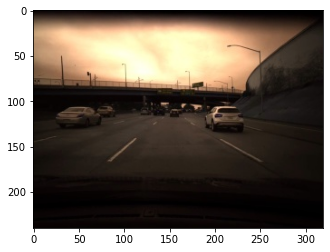

In [3]:
for path in hdf5_paths:
      with h5py.File(path, "r") as f:
        print("mean intensity of optical flow:", f["frames"][5601].mean())
        plt.imshow(f["frames"][5601]/255)
        data_size=f["speeds"].shape[0]
        print((f["frames"]).shape,'frame size')
  

train_size=int(data_size)
data_size*=augFactor

print(train_size,'number of speed data samples')
print(data_size,'real Training Size')

## Developing a time history model


20400
20398 Revised Train Size
20398 Revised Train Size Again
[20397, 20398, 20399] last Frame slice
20398 last Speed slice

Checking if within indices:
[2.2606] Last Speed Indice Value
[2.2606] Last Speed Indice Value
[2.2606] Last Speed Indice Value
[2.2606] Last Speed Indice Value


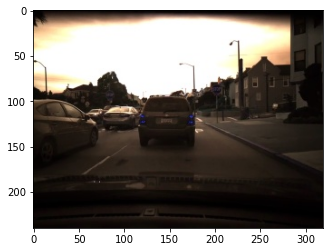

In [4]:
from statistics import median as median

time_history = 3
# All we need to do is store the indices
FrameIndices=[]
SpeedIndices=[]
train_size=int(data_size/augFactor)
print(train_size)
for j in range(0,train_size-time_history+1):
    tempFrame=[]
    for i in range(0,time_history):
        tempFrame.append(i+j)
    SpeedIndices.append(median(tempFrame))
    FrameIndices.append(tempFrame)

train_size=len(FrameIndices)
print(train_size,'Revised Train Size')


train_size=len(SpeedIndices)
print(train_size,'Revised Train Size Again')

print(FrameIndices[-1],'last Frame slice')
print(SpeedIndices[-1], 'last Speed slice')

print()
print('Checking if within indices:')
for path in hdf5_paths:
    with h5py.File(path, "r") as f:
        plt.imshow(f["frames"][FrameIndices[-1][-1]]/255)
        print(f["speeds"][SpeedIndices[-1]],'Last Speed Indice Value')

## Generator Class

In [18]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, hdf5_paths,FrameIndices,SpeedIndices,train_size,indexes = None, validation_mode = False):
        
        self.hdf5_paths = hdf5_paths
        self.FrameIndices=FrameIndices
        self.SpeedIndices=SpeedIndices
        
        
        if indexes is None:
            with indexes is None:
                 with h5py.File(self.hdf5_path, "r") as f:
                        self.indexes=np.arrange(train_size)
        else:
            self.indexes=indexes
        self.batch_size=batch_size
        self.validation_mode=validation_mode
        if self.validation_mode==False:
            print("shuffling")
            self.on_epoch_end()
       
        
            
    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.ceil(len(self.indexes)/self.batch_size))
    
    def __getitem__(self,index):
        # Generate indexes of the batch
        indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate the data
        return self.__data_generation(indexes)
    
    def on_epoch_end(self):
        # updates indexes after each epoch
        if self.validation_mode == False:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self,indexes):
        # Generates data containing batch samples
        indexes=list(indexes)
        indexes.sort()## We are making the Generator Class to read the video and the speed file
        frames=[]
        speeds=[]
        
        for paths in self.hdf5_paths:
            with h5py.File(paths, "r") as f:
                #print("[")
                for index in indexes:
                    #print(index,",",end="")
                    frames.append(f["frames"][self.FrameIndices[index]])
                    speeds.append(f["speeds"][self.SpeedIndices[index]])
                #print()
                #print("]")   
        
                        
        frames=np.array(frames)
        speeds=np.array(speeds)
        return [frames,speeds]

In [19]:
def build_model_history_combined_2(history_size):
    
    frame_inp=Input(shape=(history_size,240,320,3))
    filter_size = (3,3)
   
    
    frame=TimeDistributed(Lambda(lambda x: (x / 255.0) - 0.5))(frame_inp)
    
    frame = TimeDistributed(BatchNormalization())(frame_inp)
    frame = TimeDistributed(Dropout(.3))(frame)
    frame = TimeDistributed(Conv2D(4, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(8, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(32, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(64, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(Dropout(.3))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame = TimeDistributed(Conv2D(128, filter_size, activation = "relu", data_format = "channels_last"))(frame)
    frame = TimeDistributed(MaxPool2D())(frame)
    frame_max = TimeDistributed(GlobalMaxPool2D())(frame)
    frame_avg = TimeDistributed(GlobalAvgPool2D())(frame)
    
    conc=concatenate([frame_max,frame_avg],axis=1)
    
    conc = SpatialDropout1D(.2)(conc)
    conc = GRU(256)(conc)
    conc = Dense(100, activation = "relu")(conc)
    conc = Dropout(.2)(conc)
    conc = Dense(50, activation = "relu")(conc)
    conc = Dropout(.1)(conc)
    result = Dense(1, activation='linear')(conc)
    
    model = Model(inputs=frame_inp, outputs=[result])
    print(model.summary())
    model.compile(loss="mse", optimizer='adam')

    return model
    

In [20]:
model=build_model_history_combined_2(time_history)
train_indexes, val_indexes=train_test_split(np.arange(int(train_size)), shuffle = True, test_size = .2)

print(train_size,'Training data size per Aug')
print(train_indexes,'Train indices')
print(val_indexes,'Val indices')

maxIndexT=max(train_indexes)
maxIndexV=max(val_indexes)
print(maxIndexT,maxIndexV)

minIndexT=min(train_indexes)
minIndexV=min(val_indexes)
print(minIndexT,minIndexV)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 240, 320,  0                                            
__________________________________________________________________________________________________
time_distributed_66 (TimeDistri (None, 3, 240, 320,  12          input_5[0][0]                    
__________________________________________________________________________________________________
time_distributed_67 (TimeDistri (None, 3, 240, 320,  0           time_distributed_66[0][0]        
__________________________________________________________________________________________________
time_distributed_68 (TimeDistri (None, 3, 238, 318,  112         time_distributed_67[0][0]        
____________________________________________________________________________________________

In [21]:
train_generator=DataGenerator(5,hdf5_paths,FrameIndices,SpeedIndices,train_size,indexes=train_indexes,validation_mode=False)
valid_generator=DataGenerator(5,hdf5_paths,FrameIndices,SpeedIndices,train_size,indexes=val_indexes,validation_mode=True)
model.fit_generator(train_generator, validation_data=valid_generator, epochs = 5,callbacks=[EarlyStopping(patience=3), ModelCheckpoint(filepath="cnn_time_model_frame_mid.h5", save_weights_only=False)])

shuffling
Epoch 1/5
3264/3264 [==============================] - 6947s 2s/step - loss: 46.9714 - val_loss: 50.0969
Epoch 2/5
3264/3264 [==============================] - 7143s 2s/step - loss: 29.5869 - val_loss: 17.0906
Epoch 3/5
3264/3264 [==============================] - 8509s 3s/step - loss: 22.7566 - val_loss: 25.9272
Epoch 4/5
3264/3264 [==============================] - 8004s 2s/step - loss: 18.2969 - val_loss: 28.5135
Epoch 5/5
3264/3264 [==============================] - 7964s 2s/step - loss: 13.8605 - val_loss: 18.7213
